In [1]:
#Basic Libraries
import pandas as pd
import numpy as np
import datetime as dt


#Visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# ML Matrix + Performance params
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix


#Load the ML Algos
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
# from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.cluster import DBSCAN

# Geospatial
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio as rio
import fsspec

# API
import requests
import json

# Import Planetary Computer
# import stackstac
import pystac
import pystac_client
import planetary_computer

# Other
import os
from itertools import cycle

C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\xarray\backends\cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [2]:
 # Folder to store extracted files
storage_path = 'output'

In [3]:
df1 = pd.read_csv('Level_1_challenge_1_submission_template.csv')

In [4]:
df1.head()

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.917146,145.207706,NaN
1,1,-37.750974,144.981501,NaN
2,2,-37.961600,145.348000,NaN
3,3,-37.621300,145.003000,NaN
4,4,-38.498100,145.647000,NaN


In [5]:
df1.decimalLatitude.max()

-16.7442

In [6]:
df1.iloc[:,1:3]

,decimalLatitude,decimalLongitude
0,-37.917146,145.207706
1,-37.750974,144.981501
2,-37.961600,145.348000
3,-37.621300,145.003000
4,-38.498100,145.647000
...,...,...
4046,-31.884385,116.150192
4047,-32.412962,115.779737
4048,-32.147959,115.856628
4049,-31.827000,116.238000


In [7]:
dbscan = DBSCAN(eps=2, min_samples=10)
dbscan.fit(df1.iloc[:,1:3])

DBSCAN(eps=2, min_samples=10)

In [8]:
dbscan.labels_

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [9]:
data_dbscan = df1.iloc[:,1:3].copy()
data_dbscan['clusters_dbscan'] = dbscan.labels_
data_dbscan['clusters_dbscan'].value_counts()

0    1491
1    1171
2     663
4     598
3     128
Name: clusters_dbscan, dtype: int64

In [10]:
data_dbscan

,decimalLatitude,decimalLongitude,clusters_dbscan
0,-37.917146,145.207706,0
1,-37.750974,144.981501,0
2,-37.961600,145.348000,0
3,-37.621300,145.003000,0
4,-38.498100,145.647000,0
...,...,...,...
4046,-31.884385,116.150192,4
4047,-32.412962,115.779737,4
4048,-32.147959,115.856628,4
4049,-31.827000,116.238000,4


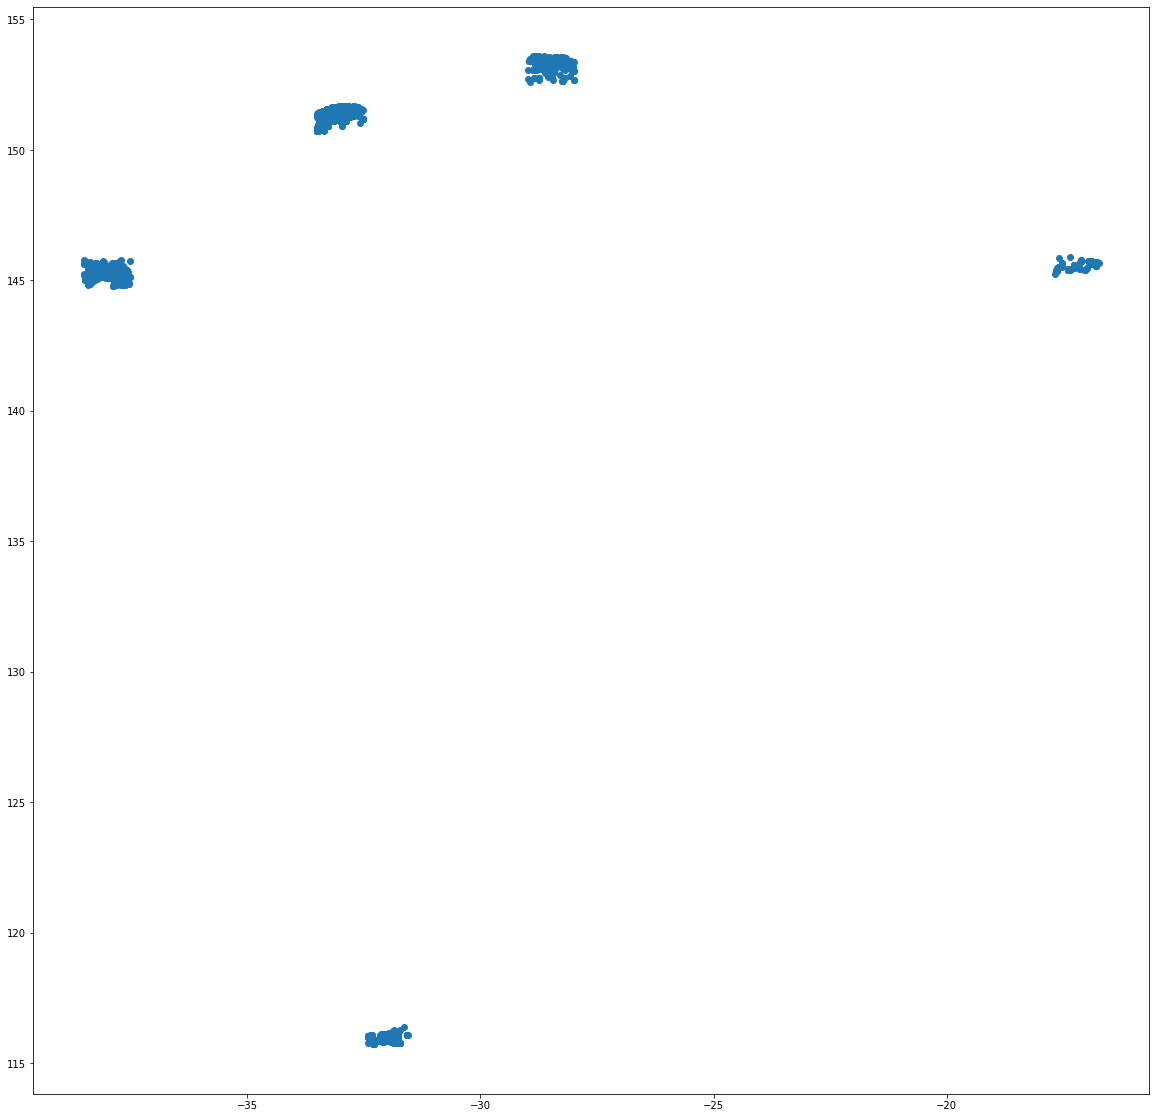

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.scatter(df1.decimalLatitude,df1.decimalLongitude)

In [12]:
data_dbscan.clusters_dbscan.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [13]:
d = 9

print(f'The age of my car is {d}')

The age of my car is 9


In [14]:
def plot_bbox_cluster(data):
    bbox_dict = {}
    fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    plt.scatter(data.decimalLatitude,data.decimalLongitude)
    #{clusterno:[min_lon,min_lat,max_lon, max_lat]}
    for x in list(data.clusters_dbscan.unique()):
        cluster_temp = data_dbscan.loc[data_dbscan.clusters_dbscan == x].copy()
        max_lat = cluster_temp.decimalLatitude.max()
        min_lat = cluster_temp.decimalLatitude.min()
        max_lon = cluster_temp.decimalLongitude.max()
        min_lon = cluster_temp.decimalLongitude.min()
        bbox_dict[f'{x}']=(min_lon,min_lat,max_lon, max_lat)
        left, bottom, width, height = (min_lat-0.25, min_lon-0.25, (max_lat-min_lat)+0.5, (max_lon-min_lon)+0.5)
        rect=mpatches.Rectangle((left,bottom),width,height, 
                        #fill=False,
                        alpha=0.5,
                       facecolor="red")
        plt.gca().add_patch(rect)
        
    plt.show()
    return bbox_dict

        
    
    

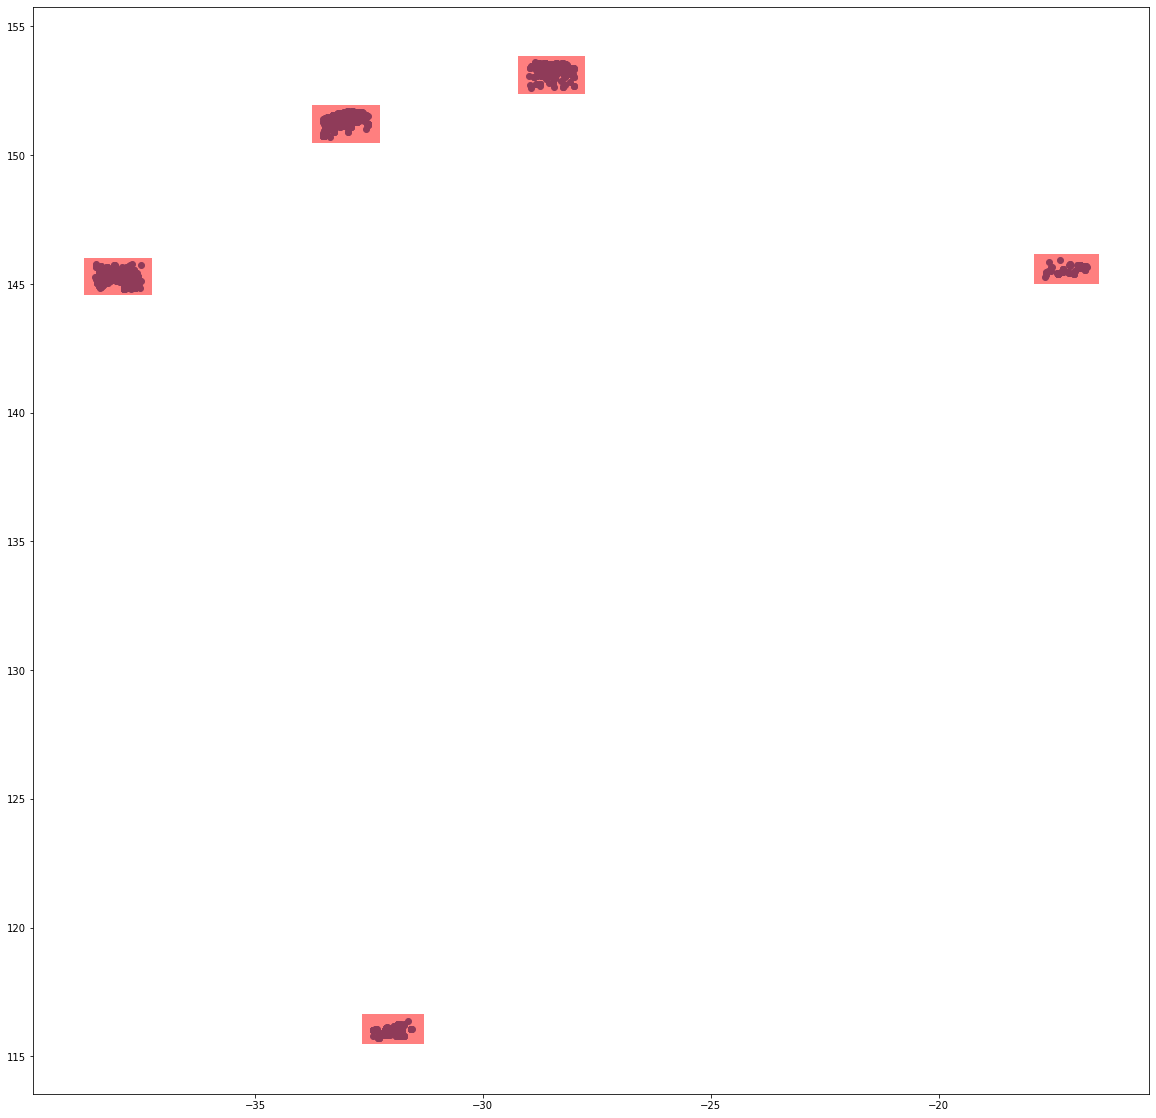

In [15]:
bbox_coordinates = plot_bbox_cluster(data_dbscan)

In [16]:
bbox_coordinates

{'0': (144.800515, -38.49989934, 145.7671922, -37.51085308),
 '1': (150.71, -33.49989273, 151.6999572, -32.51836843),
 '2': (152.61, -28.99, 153.6, -28.00067739),
 '3': (145.2511412, -17.67161479, 145.911, -16.7442),
 '4': (115.7160036, -32.41296172, 116.3773691, -31.5516)}

In [17]:
for x in bbox_coordinates:
    print(bbox_coordinates[x])

(144.800515, -38.49989934, 145.7671922, -37.51085308)
(150.71, -33.49989273, 151.6999572, -32.51836843)
(152.61, -28.99, 153.6, -28.00067739)
(145.2511412, -17.67161479, 145.911, -16.7442)
(115.7160036, -32.41296172, 116.3773691, -31.5516)


In [18]:
def filter_bbox(frogs, bbox_clusters):
    frogs_fnl = pd.DataFrame()
    for y in bbox_clusters:
        frogs_temp = frogs[lambda x: 
            (x.decimalLongitude >= bbox_clusters[y][0]) &
            (x.decimalLatitude >= bbox_clusters[y][1]) &
            (x.decimalLongitude <= bbox_clusters[y][2]) &
            (x.decimalLatitude <= bbox_clusters[y][3])    ]
        frogs_temp.cluster = y
        frogs_fnl = pd.concat([frogs_fnl,frogs_temp])
    return frogs_fnl

def get_frogs(file, year_range=None, bbox_clusters=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv('occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    
    frogs['cluster'] = np.nan
    
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox_clusters is not None:
        frogs = filter_bbox(frogs, bbox_clusters)
    return frogs

In [19]:
# Load in data
all_frog_data = get_frogs('occurrence.txt', year_range=(2015, 2021), bbox_clusters=bbox_coordinates)
all_frog_data

C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\ipykernel_launcher.py:2: DtypeWarning: Columns (2,9,35,39,42,46,47,48,54,56,57,58,59,60,62,64,65,66,68,69,70,71,74,75,76,77,78,79,82,84,85,86,87,88,89,90,92,96,97,99,101,103,109,110,111,114,115,116,117,118,119,120,121,122,123,126,127,128,129,130,135,136,142,143,145,147,148,149,150,151,161,165,170,172,173,174,175,176,177,178,179,180,181,185,189,190,191,192,193,195,207,210,212,215,217,225,226,242,246,254,255) have mixed types.Specify dtype option on import or set low_memory=False.
  
C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,cluster
2780,1633803922,2017-08-05 20:51:00,Australia,Australia,Victoria,-38.045122,145.326047,Crinia Signifera,0
3279,3384896595,2021-10-07 07:58:39,Australia,Australia,Victoria,-38.030947,145.432053,Crinia Signifera,0
4737,3463456338,2018-11-09 00:00:00,Australia,Australia,Victoria,-38.088716,145.722909,Crinia Signifera,0
4780,3463456499,2019-07-30 00:00:00,Australia,Australia,Victoria,-37.807553,145.263607,Crinia Signifera,0
4787,3463456516,2020-08-23 00:00:00,Australia,Australia,Victoria,-37.991842,145.118825,Crinia Signifera,0
...,...,...,...,...,...,...,...,...,...
95809,1640023933,2017-09-09 16:00:00,Australia,Australia,Western Australia,-31.933553,115.909463,Crinia Glauerti,4
95839,1632969821,2016-04-13 08:04:00,Australia,Australia,Western Australia,-32.014768,115.895289,Crinia Glauerti,4
149899,3381434234,2017-11-18 00:00:00,Australia,Australia,Western Australia,-32.242003,115.834441,Crinia Signifera,4
151331,3381443465,2017-11-17 00:00:00,Australia,Australia,Western Australia,-31.775465,115.742627,Crinia Signifera,4


In [20]:
all_frog_data.cluster.value_counts()

1    13003
4     6691
0     5244
2     2325
3     1138
Name: cluster, dtype: int64

In [21]:
all_frog_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28401 entries, 2780 to 152823
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gbifID            28401 non-null  int64         
 1   eventDate         28401 non-null  datetime64[ns]
 2   country           28401 non-null  object        
 3   continent         28401 non-null  object        
 4   stateProvince     28401 non-null  object        
 5   decimalLatitude   28401 non-null  float64       
 6   decimalLongitude  28401 non-null  float64       
 7   species           28401 non-null  object        
 8   cluster           28401 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 2.2+ MB


In [22]:
all_frog_data.species.value_counts() #Class imbalance exits

Crinia Signifera             11875
Litoria Fallax                9705
Crinia Glauerti               6688
Austrochaperina Pluvialis      133
Name: species, dtype: int64

In [23]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .reset_index(drop=True).assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0),
        key= lambda x: x.index
    )
)
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,cluster,occurrenceStatus,key
0,1633803922,2017-08-05 20:51:00,Australia,Australia,Victoria,-38.045122,145.326047,Crinia Signifera,0,0,0
1,3384896595,2021-10-07 07:58:39,Australia,Australia,Victoria,-38.030947,145.432053,Crinia Signifera,0,0,1
2,3463456338,2018-11-09 00:00:00,Australia,Australia,Victoria,-38.088716,145.722909,Crinia Signifera,0,0,2
3,3463456499,2019-07-30 00:00:00,Australia,Australia,Victoria,-37.807553,145.263607,Crinia Signifera,0,0,3
4,3463456516,2020-08-23 00:00:00,Australia,Australia,Victoria,-37.991842,145.118825,Crinia Signifera,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...
28396,1640023933,2017-09-09 16:00:00,Australia,Australia,Western Australia,-31.933553,115.909463,Crinia Glauerti,4,0,28396
28397,1632969821,2016-04-13 08:04:00,Australia,Australia,Western Australia,-32.014768,115.895289,Crinia Glauerti,4,0,28397
28398,3381434234,2017-11-18 00:00:00,Australia,Australia,Western Australia,-32.242003,115.834441,Crinia Signifera,4,0,28398
28399,3381443465,2017-11-17 00:00:00,Australia,Australia,Western Australia,-31.775465,115.742627,Crinia Signifera,4,0,28399


In [24]:
all_frog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28401 entries, 0 to 28400
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gbifID            28401 non-null  int64         
 1   eventDate         28401 non-null  datetime64[ns]
 2   country           28401 non-null  object        
 3   continent         28401 non-null  object        
 4   stateProvince     28401 non-null  object        
 5   decimalLatitude   28401 non-null  float64       
 6   decimalLongitude  28401 non-null  float64       
 7   species           28401 non-null  object        
 8   cluster           28401 non-null  object        
 9   occurrenceStatus  28401 non-null  int32         
 10  key               28401 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(5)
memory usage: 2.3+ MB


In [25]:
len(all_frog_data.key.unique())

28401

In [26]:
all_frog_data.occurrenceStatus.value_counts()

0    18696
1     9705
Name: occurrenceStatus, dtype: int64

In [27]:
all_frog_data["Year"] = all_frog_data.eventDate.dt.year

In [28]:
all_frog_data.groupby('Year').count()

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,cluster,occurrenceStatus,key
Year,,,,,,,,,,,
2015,578,578,578,578,578,578,578,578,578,578,578
2016,284,284,284,284,284,284,284,284,284,284,284
2017,1363,1363,1363,1363,1363,1363,1363,1363,1363,1363,1363
2018,5910,5910,5910,5910,5910,5910,5910,5910,5910,5910,5910
2019,8665,8665,8665,8665,8665,8665,8665,8665,8665,8665,8665
2020,11306,11306,11306,11306,11306,11306,11306,11306,11306,11306,11306
2021,295,295,295,295,295,295,295,295,295,295,295


In [29]:
frog_trend = all_frog_data.groupby('Year').count()['occurrenceStatus'].copy()

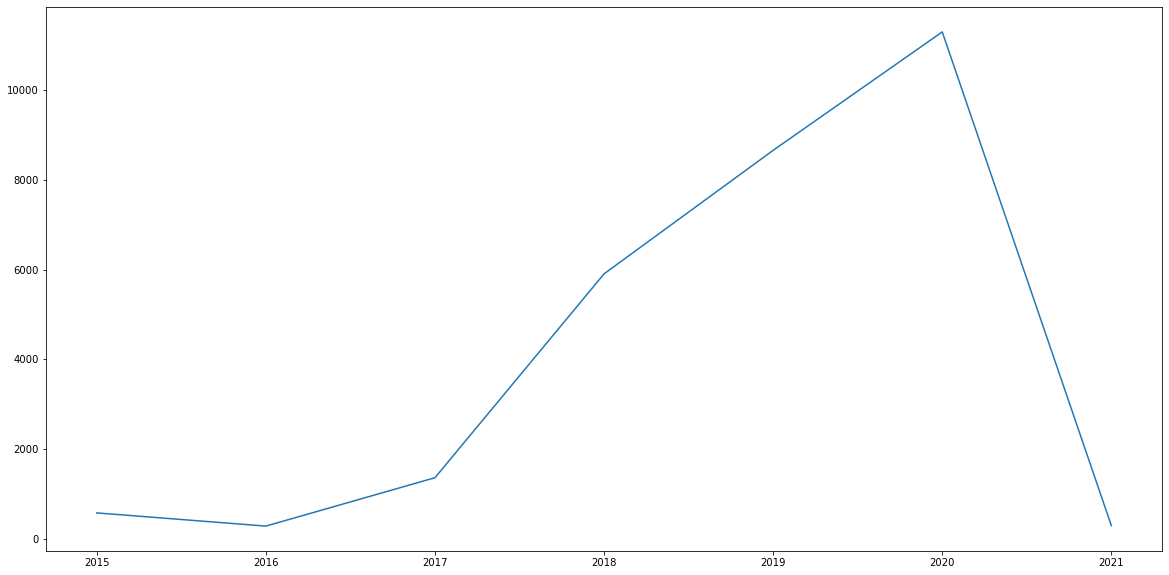

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plt.plot(frog_trend)

Text(0.5, 1.0, 'Training set for Aus')

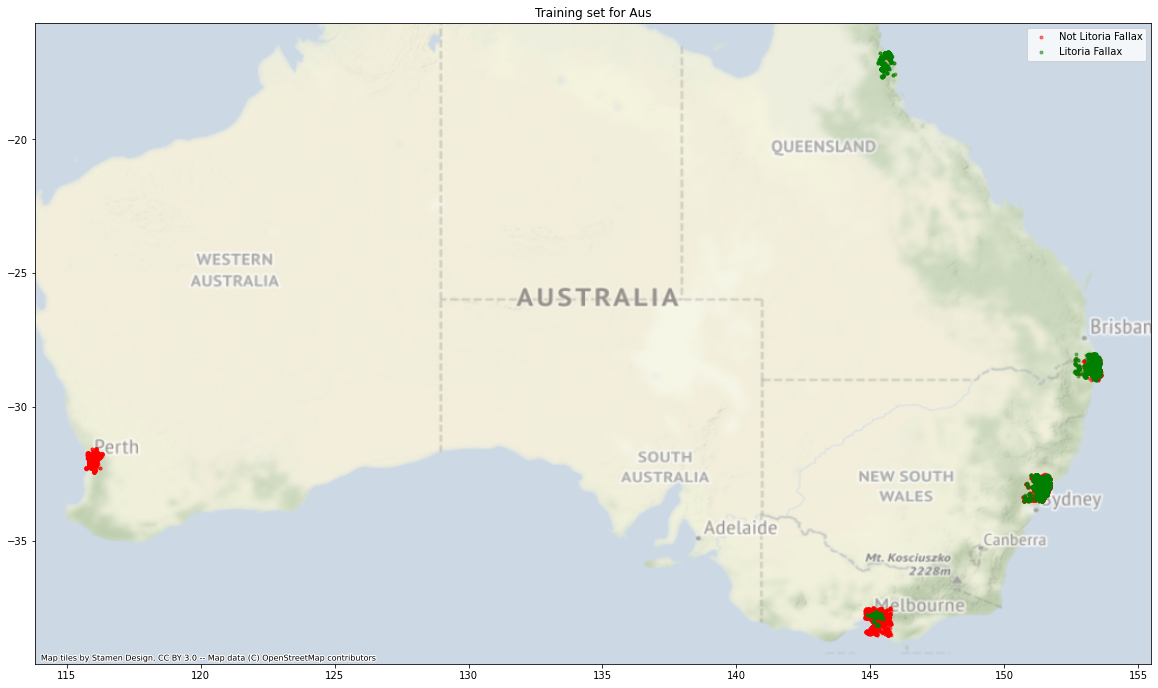

In [31]:
fig, ax = plt.subplots(figsize = (20, 20))

filt = all_frog_data.occurrenceStatus == 1
ax.scatter(all_frog_data[~filt].decimalLongitude, all_frog_data[~filt].decimalLatitude,
           color = 'red', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.scatter(all_frog_data[filt].decimalLongitude, all_frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for Aus")

In [32]:
for x in bbox_coordinates.values():
    print(x)

(144.800515, -38.49989934, 145.7671922, -37.51085308)
(150.71, -33.49989273, 151.6999572, -32.51836843)
(152.61, -28.99, 153.6, -28.00067739)
(145.2511412, -17.67161479, 145.911, -16.7442)
(115.7160036, -32.41296172, 116.3773691, -31.5516)


In [33]:
all_frog_data.columns


Index(['gbifID', 'eventDate', 'country', 'continent', 'stateProvince',
       'decimalLatitude', 'decimalLongitude', 'species', 'cluster',
       'occurrenceStatus', 'key', 'Year'],
      dtype='object')

In [34]:
from imblearn.combine import SMOTETomek
from collections import Counter



X_balance = all_frog_data[[ 'decimalLatitude', 'decimalLongitude','cluster']]
y_balance = all_frog_data['occurrenceStatus']

# summarize class distribution
print(Counter(y_balance))

smt = SMOTETomek(sampling_strategy = 'auto')
X_res, y_res = smt.fit_resample(X_balance, y_balance)

all_frog_data = pd.concat([X_res, y_res], axis=1)
# summarize class distribution
print(Counter(y_res))

Counter({0: 18696, 1: 9705})
Counter({0: 18561, 1: 18561})


In [35]:
all_frog_data = (
    all_frog_data.reset_index(drop=True).assign(key= lambda x: x.index))
all_frog_data

,decimalLatitude,decimalLongitude,cluster,occurrenceStatus,key
0,-38.045122,145.326047,0.0,0,0
1,-38.030947,145.432053,0.0,0,1
2,-38.088716,145.722909,0.0,0,2
3,-37.807553,145.263607,0.0,0,3
4,-37.991842,145.118825,0.0,0,4
...,...,...,...,...,...
37117,-33.324700,151.364000,1.0,1,37117
37118,-33.045600,151.391000,1.0,1,37118
37119,-28.807479,153.582000,2.0,1,37119
37120,-28.794192,153.370808,2.0,1,37120


In [37]:
all_frog_data.cluster = all_frog_data.cluster.astype(int)
all_frog_data.cluster.value_counts()

1    19166
4     6691
0     5325
2     3897
3     2043
Name: cluster, dtype: int64

In [45]:
all_frog_data.groupby(['cluster','occurrenceStatus']).count()['key']

cluster  occurrenceStatus
0        0                    5070
         1                     255
1        0                    6135
         1                   13031
2        0                     535
         1                    3362
3        0                     130
         1                    1913
4        0                    6691
Name: key, dtype: int64

In [61]:
for bbox_num in range(len(bbox_coordinates)):
    print(list(bbox_coordinates.values())[bbox_num])

(144.800515, -38.49989934, 145.7671922, -37.51085308)
(150.71, -33.49989273, 151.6999572, -32.51836843)
(152.61, -28.99, 153.6, -28.00067739)
(145.2511412, -17.67161479, 145.911, -16.7442)
(115.7160036, -32.41296172, 116.3773691, -31.5516)


In [64]:
def get_terraclimate(bbox_coordinates, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    clusters_combined = []
    
    for bbox in bbox_coordinates.values():
        min_lon, min_lat, max_lon, max_lat = bbox
    
        collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
        asset = collection.assets["zarr-https"]
        store = fsspec.get_mapper(asset.href)
        data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])

        # Select datapoints that overlap region
        if time_slice is not None:
            data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
        else:
            data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
        if assets is not None:
            data = data[assets]
        print('Loading data') if verbose else None
        data = data.rename(lat='y', lon='x').to_array().compute()

        # Calculate metrics
        combined_values = []
        combined_bands = []
        for name, metric in metrics.items():
            print(f'Calculating {name}') if verbose else None
            sum_data = xr.apply_ufunc(
                metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
            ).rename(variable='band')
            xcoords = sum_data.x
            ycoords = sum_data.y
            dims = sum_data.dims
            combined_values.append(sum_data.values)
            for band in sum_data.band.values:
                combined_bands.append(band+'_'+name)

        # Combine metrics
        combined_values = np.concatenate(
            combined_values,
            axis=0
        )
        combined_data = xr.DataArray(
            data=combined_values,
            dims=dims,
            coords=dict(
                band=combined_bands,
                y=ycoords,
                x=xcoords
            )
        )    

        # Take relevant bands:
        combined_data = combined_data.sel(band=features)

        if interp_dims is not None:
            print(f'Interpolating image') if verbose else None
            interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
            combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
        
        clusters_combined.append(combined_data)
        
    combined_clusters_data = xr.concat(clusters_combined, dim='bbox')
    return combined_clusters_data

In [ ]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2021-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil']

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox_coordinates, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\xarray\backends\plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Loading data
Calculating mean


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))


Calculating min
Calculating max
Interpolating image


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


Loading data
Calculating mean
Calculating min


C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: Mean of empty slice
  results = func(*(arg[index] for arg in args))
C:\Users\LR996GB\Anaconda3\envs\frogs\lib\site-packages\numpy\lib\function_base.py:2277: RuntimeWarning: All-NaN slice encountered
  results = func(*(arg[index] for arg in args))


Calculating max
Interpolating image
Loading data


In [ ]:
nrow = 2
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 7))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

In [ ]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(all_frog_data.decimalLongitude, dims="key", coords={"key": all_frog_data.key}), 
                y=xr.DataArray(all_frog_data.decimalLatitude, dims="key", coords={"key": all_frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot_table(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )
    
model_data = join_frogs(all_frog_data, weather_data)
model_data.head()

In [ ]:
model_data.describe()

In [ ]:
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['decimalLatitude', 'decimalLongitude', 'occurrenceStatus', 'key'], 1)
)
y = model_data.occurrenceStatus.astype(int)

In [ ]:
#PREDICTOR VARIABLES
X

In [ ]:
#TARGET VARIABLES
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5) 

In [ ]:
def report(model):
    preds = model.predict(X_test)
    print(classification_report(y_test,preds))
    plot_confusion_matrix(model,X_test,y_test)
    print(f"F1 Score: {np.mean(f1_score(y_test, preds)).round(2)}")
    print(f"Accuracy: {np.mean(accuracy_score(y_test, preds)).round(2)}")

In [ ]:
### Logisitic Regression

LR = LogisticRegression()

#Parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [600, 700, 300, 250]

#ParametersGrid
lr_param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

#GridSearchCV
gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsLR.fit(X_train,y_train)

In [ ]:
# Summarize the results
LR_best = gsLR.best_estimator_
print('Best : {}, using {}'.format(gsLR.best_score_,gsLR.best_params_))
report(gsLR)

# Train the model
LSVC = LinearSVC()

#Parameters
class_weight=[None]
dual=[True]
tol=[1e-3,1e-2]
max_iter=[1e5]

#ParametersGrid
lsvc_param_grid = dict(class_weight=class_weight,dual=dual,tol=tol,max_iter=max_iter)

#GridSearchCV
gsLSVC = GridSearchCV(LSVC,param_grid = lsvc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsLSVC.fit(X_train,y_train)

#Summarize the results
LSVC_best = gsLSVC.best_estimator_
print('Best : {}, using {}'.format(gsLSVC.best_score_,gsLSVC.best_params_))
report(gsLSVC)

In [ ]:
# Train the model
RFC = RandomForestClassifier()


#Parameters
rf_param_grid = {"max_depth": [13,14,15],
              "bootstrap": [True, False],
              "n_estimators" :[36,37,38],
              "criterion": ["gini"]}

#GridSearchCV
gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1", n_jobs= -1, verbose = 1)
gsRFC.fit(X_train,y_train)

In [ ]:
# Summarize the results
RFC_best = gsRFC.best_estimator_
print('Best : {}, using {}'.format(gsRFC.best_score_,gsRFC.best_params_))
report(gsRFC)

In [ ]:
df1

In [ ]:
def join_frogs_sub(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(df1.decimalLongitude, dims="id", coords={"id": df1.id}), 
                y=xr.DataArray(df1.decimalLatitude, dims="id", coords={"id": df1.id}),
                method="nearest"
            )
            .to_dataframe()
#             .assign(val = lambda x: x.iloc[:, -1])
#             [['val']]
#             .reset_index()
#             .drop_duplicates()
#             .pivot(index="id", columns="band", values="val")
#             .reset_index()
        ),
        on = ['id'],
        how = 'inner'
    )
    
test_data = join_frogs_sub(df1, weather_data)
test_data.head()

In [ ]:
test_data.iloc[:,-4:]

In [ ]:
test_result = gsRFC.predict(test_data.iloc[:,-4:])
test_result

In [ ]:
df1